## Техники AutoAugment и CutOut, адаптированные под CIFAR-10

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchinfo
import matplotlib.pyplot as plt
import numpy as np
import time
import random
import PIL.ImageOps as ImageOps
import PIL.ImageEnhance as ImageEnhance
import PIL.Image as Image
from operator import truediv, neg
import torch.nn.functional as F

random_seed = 0
torch.manual_seed(random_seed)

class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10), # перекос изображения
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10), # параллельный сдвиг (в процентах)
            "rotate": np.linspace(0, 30, 10), # поворот с 10-ю дискретными шагами от 0 до 30 градусов
            "color": np.linspace(0.0, 0.9, 10), # насыщенность цвета
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int), # эффект постеризации за счет сокращения количества цветов
            "solarize": np.linspace(256, 0, 10), # пиксели, превышающие пороговое значение, инвертируются по формуле 255 - <значения каналов пикселя>
            "contrast": np.linspace(0.0, 0.9, 10), # контрастность
            "sharpness": np.linspace(0.0, 0.9, 10), # резкость
            "brightness": np.linspace(0.0, 0.9, 10), # яркость
            "autocontrast": [0] * 10, # нормализация контрастности изображения
            "equalize": [0] * 10, # выравнивание гистограммы изображения
            "invert": [0] * 10 # инверсия цветов
        }

        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]

    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

class CIFAR10Policy(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor), # каждая SubPolicy с вероятностями p1 и p2 применяет 
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor), # две аугментации с определенными уровнями интенсивности
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),
            
            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),
            
            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),
            
            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),
            
            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

class CutoutAfterToTensor(object):
    def __init__(self, n_holes, length, fill_color=torch.tensor([0,0,0])):
        self.n_holes = n_holes
        self.length = length
        self.fill_color = fill_color

    def __call__(self, img):
        h = img.shape[1]
        w = img.shape[2]
        mask = np.ones((h, w), np.float32)
        for n in range(self.n_holes): # n_holes - количество квадратных областей
            y = np.random.randint(h)
            x = np.random.randint(w) # x,y - координаты центра квадратной области
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w) # обрезка квадратной области, чтобы не выходила за границы изображения
            mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask + (1 - mask) * self.fill_color[:, None, None] # накладываем маску на изображение, 
                                                                       # квадратная область не должна создавать резкий контраст
        return img

## Проверка целостности данных:

Загрузка датасета CIFAR-10:


100%|██████████| 170M/170M [00:02<00:00, 78.8MB/s] 


Размер тренировочного набора: 50000
Размер тестового набора: 10000

Проверка целостности данных:
Размер изображения после применения преобразований transform к тренировочному набору: torch.Size([3, 32, 32])
Тип данных изображения: torch.float32
Размер изображения после применения преобразований transform к тестовому набору: torch.Size([3, 32, 32])
Тип данных изображения: torch.float32

Уникальные метки классов в тренировочном наборе: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Количество классов в тренировочном наборе: 10
Названия классов: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Уникальные метки классов в тестовом наборе: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Количество классов в тестовом наборе: 10
Названия классов: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Распределение классов в тренировочном наборе:
  plane   : 5000 изображений
  car     : 5000 изображений
  bird    : 5000 изображений
  cat     : 5000 изображений
  deer  

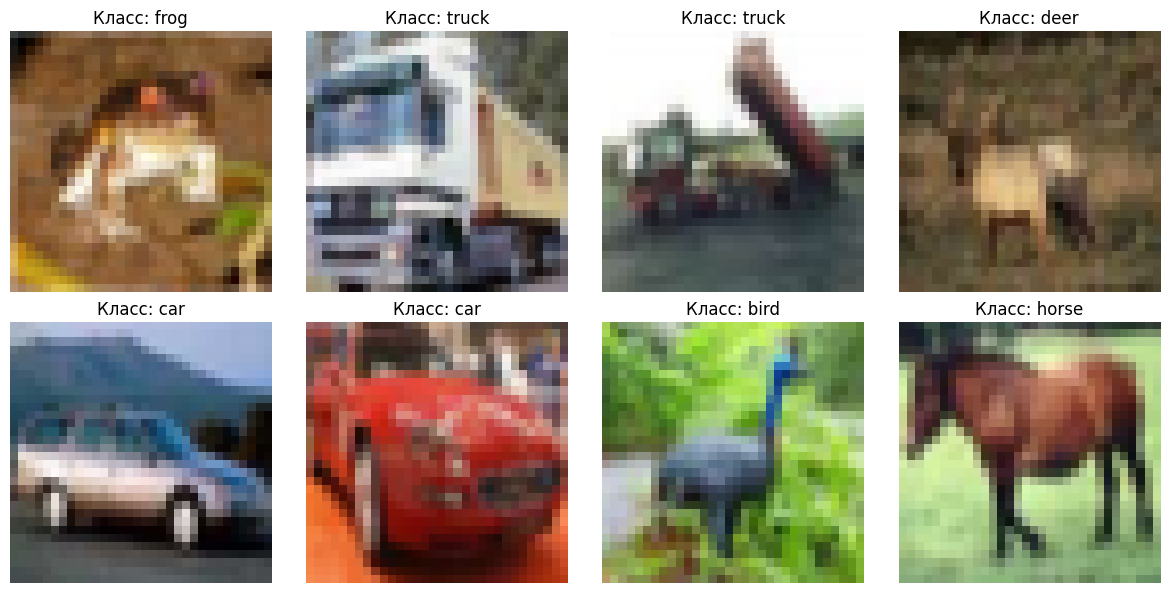


Визуализация данных из тестового набора:


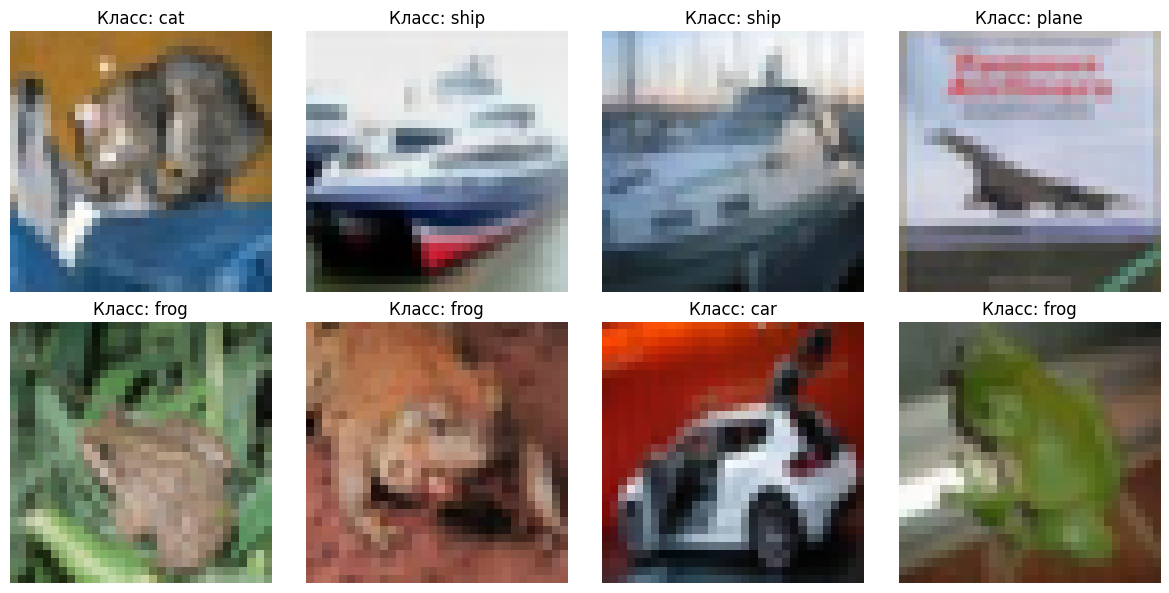

In [3]:
image_size = 32
cutout = image_size // 2
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # (средние значения по каждому каналу), (стандартные отклонения по каждому каналу) для cifar-10
mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618] # среднее значение по каждому каналу для датасета cifar-10
data_mean = torch.tensor(mean)
data_mean_int = tuple([int(255 * c) for c in data_mean]) # для совместимости с PIL

train_tfms = transforms.Compose([
    transforms.RandomCrop(image_size, padding=4, padding_mode='reflect'), 
    transforms.RandomHorizontalFlip(),
    CIFAR10Policy(fillcolor=data_mean_int),
    transforms.ToTensor(), 
    CutoutAfterToTensor(n_holes=1, length=cutout, fill_color=data_mean),
    transforms.Normalize(*stats, inplace=True)
])

valid_tfms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(*stats)
])

print('Загрузка датасета CIFAR-10:')
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tfms)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=valid_tfms)

batch_size = 400
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size*2, pin_memory=True)

print(f'Размер тренировочного набора: {len(trainset)}')
print(f'Размер тестового набора: {len(testset)}')

# Названия классов
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Проверка данных
print('\nПроверка целостности данных:')

# Получаем одно изображение для проверки
sample_img, _ = trainset[0]
print(f'Размер изображения после применения преобразований transform к тренировочному набору: {sample_img.shape}')
print(f'Тип данных изображения: {sample_img.dtype}')
sample_img2, _ = testset[0]
print(f'Размер изображения после применения преобразований transform к тестовому набору: {sample_img2.shape}')
print(f'Тип данных изображения: {sample_img2.dtype}')

# Проверка меток
all_labels = [label for _, label in trainset]
unique_labels = sorted(set(all_labels))
print(f'\nУникальные метки классов в тренировочном наборе: {unique_labels}')
print(f'Количество классов в тренировочном наборе: {len(unique_labels)}')
print(f'Названия классов: {classes}')

all_labels2 = [label for _, label in testset]
unique_labels2 = sorted(set(all_labels2))
print(f'Уникальные метки классов в тестовом наборе: {unique_labels2}')
print(f'Количество классов в тестовом наборе: {len(unique_labels2)}')
print(f'Названия классов: {classes}')

# Распределение классов
from collections import Counter
label_counts = Counter(all_labels)
print(f'\nРаспределение классов в тренировочном наборе:')
for i in range(10):
    print(f'  {classes[i]:8s}: {label_counts[i]} изображений')

all_labels2 = [label for _, label in testset]
label_counts2 = Counter(all_labels2)
print(f'\nРаспределение классов в тестовом наборе:')
for i in range(10):
    print(f'  {classes[i]:8s}: {label_counts2[i]} изображений')

# Проверка формы batch после DataLoader
train_batch = next(iter(trainloader))
train_images, train_labels = next(iter(trainloader))
print(f'\nФорма батча из тренировочного набора: {train_batch[0].shape},')
print(f'где [{train_batch[0].shape[0]}, {train_batch[0].shape[1]}, {train_batch[0].shape[2]}, {train_batch[0].shape[3]}] = [batch_size, channels, height, width]')
print(f'Форма меток батча из тренировочного набора: {train_batch[1].shape}')

# Получаем случайные изображения
dataiter = iter(testloader)
test_images, test_labels = next(dataiter)
print(f'\nФорма батча из тестового набора: {test_images.shape}')
print(f'Форма меток батча из тестового набора: {test_labels.shape}')

def show_images(loader):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        img = loader.dataset.data[i]
        label = loader.dataset.targets[i]
        
        ax.imshow(img)
        ax.set_title(f'Класс: {classes[label]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print("\nВизуализация данных из тренировочного набора:")
show_images(trainloader)

print("\nВизуализация данных из тестового набора:")
show_images(testloader)

## Визуализация преобразованных изображений:

In [4]:
class UnNormalize(transforms.Normalize):
    def __init__(self, mean, std, inplace=False): # денормализация преобразованных изображений для их корректной визуализации
        meanoverstd = tuple(map(truediv, mean, std))
        negmeanoverstd = tuple(map(neg, meanoverstd))
        oneoverstd = tuple(map(truediv, (1.0,1.0,1.0), std))
        super().__init__(negmeanoverstd, oneoverstd)

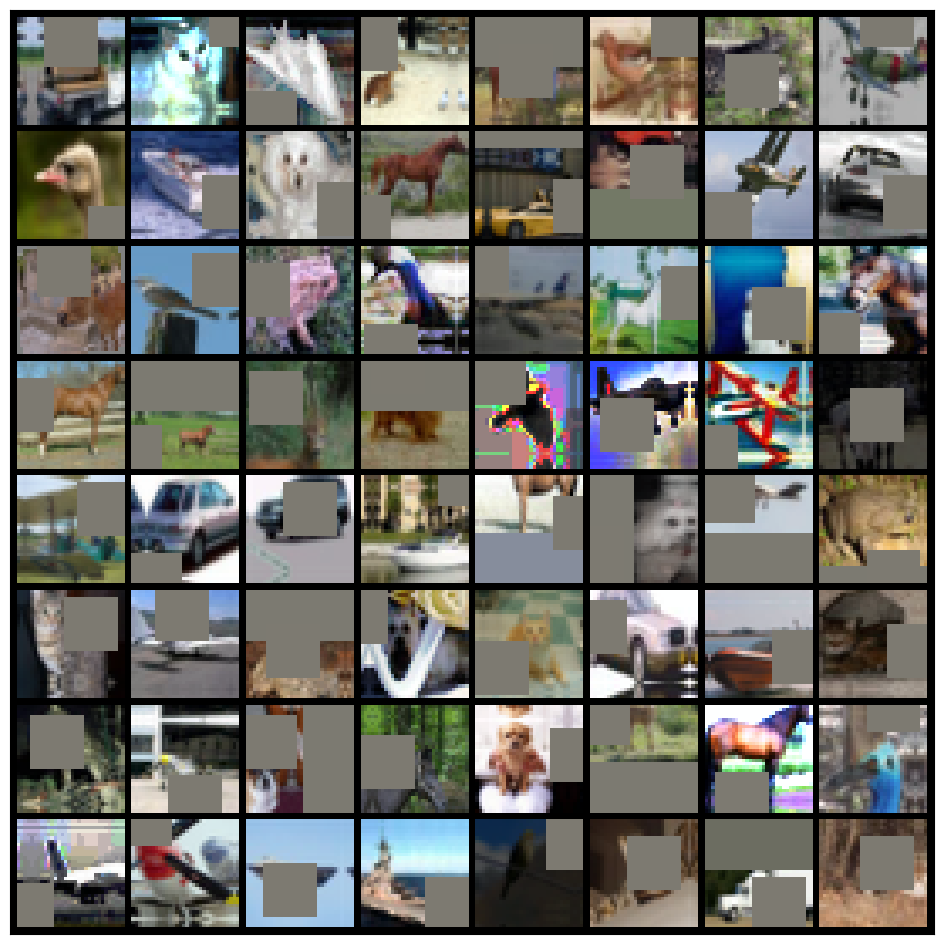

In [5]:
un = UnNormalize(stats[0], stats[1])

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        images = un(images[:64])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

show_batch(trainloader)

## Размещение тренировочного и тестового датасетов на GPU:

In [5]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device) # ленивое возвращение батча на GPU
            
    def __len__(self):
        return len(self.dl)

def to_device(data, device):
    if isinstance(data, (list,tuple)): # перемещение всех параметров модели на GPU
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\nИспользуется устройство: {device}')

trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)


Используется устройство: cuda


## Определение архитектуры WideResNet:

В нейронных сетях без skip connection каждый слой сети путем изменения её параметров настраивает преобразование $H(x)$ таким образом, чтобы добиться оптимального значения функции ошибки (здесь $x$ - вход слоя). В ResNet вместо настройки
$H(x)$ происходит настройка остаточного преобразования $F(x)$, такого что: $$H(x) = F(x) + x,$$
где $F(x)$ - выход свёрточных слоёв внутри residual block, $x$ - исходный вход (skip connection).

При обратном распространении ошибки градиент рассчитывается как:
$$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial H(x)} \cdot \frac{\partial H(x)}{\partial x} = \frac{\partial L}{\partial H(x)} \cdot \left(\frac{\partial F(x)}{\partial x} + 1 \right),$$
где $L$ - функция потерь. Таким образом, мы видим, что при затухании градиента $\frac{\partial F(x)}{\partial x} \to 0$ в глубоких нейронных сетях (проблема деградации) общий градиент $\frac{\partial L}{\partial x}$ ввиду наличия слагаемого +1 не обратится в нуль.

In [6]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # out_channels - количество выходных карт признаков
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class WideResNet(nn.Module):
    def __init__(self, in_channels, num_classes, first_conv_features=128):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, first_conv_features)
        self.conv2 = conv_block(first_conv_features, first_conv_features*2, pool=True)
        self.res1 = nn.Sequential(conv_block(first_conv_features*2, first_conv_features*2), 
                                  conv_block(first_conv_features*2, first_conv_features*2))
        
        self.conv3 = conv_block(first_conv_features*2, first_conv_features*4, pool=True)
        self.conv4 = conv_block(first_conv_features*4, first_conv_features*8, pool=True)
        self.res2 = nn.Sequential(conv_block(first_conv_features*8, first_conv_features*8), 
                                  conv_block(first_conv_features*8, first_conv_features*8))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(first_conv_features*8, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# WideResNet - ResNet с расширением количества фильтров в x2.625 (было 64 стало 168 начальных фильтров)
model = to_device(WideResNet(3, 10, first_conv_features=168), device)

## Отчет о структуре модели:

In [7]:
torchinfo.summary(model, (3, image_size, image_size), batch_dim = 0, col_width = 20, col_names = ('input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'), verbose = 0)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds
WideResNet                               [1, 3, 32, 32]       [1, 10]              --                   --                   --
├─Sequential: 1-1                        [1, 3, 32, 32]       [1, 168, 32, 32]     --                   --                   --
│    └─Conv2d: 2-1                       [1, 3, 32, 32]       [1, 168, 32, 32]     4,704                [3, 3]               4,816,896
│    └─BatchNorm2d: 2-2                  [1, 168, 32, 32]     [1, 168, 32, 32]     336                  --                   336
│    └─ReLU: 2-3                         [1, 168, 32, 32]     [1, 168, 32, 32]     --                   --                   --
├─Sequential: 1-2                        [1, 168, 32, 32]     [1, 336, 16, 16]     --                   --                   --
│    └─Conv2d: 2-4                       [1, 168, 32, 32]     [1, 336, 32, 32]     508,36

## Обучение модели:


Гиперпараметры:
Скорость обучения: 0.007
Размер batch: 400
Количество эпох: 50
Оптимизатор: AdamW

Начало обучения...

Эпоха 1/50:
  Ошибка на тренировочном наборе: 1.3314
  Точность на тренировочном наборе: 53.31%
  Время выполнения эпохи: 137.67 секунд

Эпоха 2/50:
  Ошибка на тренировочном наборе: 1.1421
  Точность на тренировочном наборе: 60.00%
  Время выполнения эпохи: 136.54 секунд

Эпоха 3/50:
  Ошибка на тренировочном наборе: 1.0628
  Точность на тренировочном наборе: 63.11%
  Время выполнения эпохи: 137.81 секунд

Эпоха 4/50:
  Ошибка на тренировочном наборе: 1.0346
  Точность на тренировочном наборе: 64.07%
  Время выполнения эпохи: 136.88 секунд

Эпоха 5/50:
  Ошибка на тренировочном наборе: 1.0076
  Точность на тренировочном наборе: 64.94%
  Время выполнения эпохи: 137.53 секунд

Эпоха 6/50:
  Ошибка на тренировочном наборе: 0.9823
  Точность на тренировочном наборе: 66.01%
  Время выполнения эпохи: 137.53 секунд

Эпоха 7/50:
  Ошибка на тренировочном наборе: 0.9922
  Точ

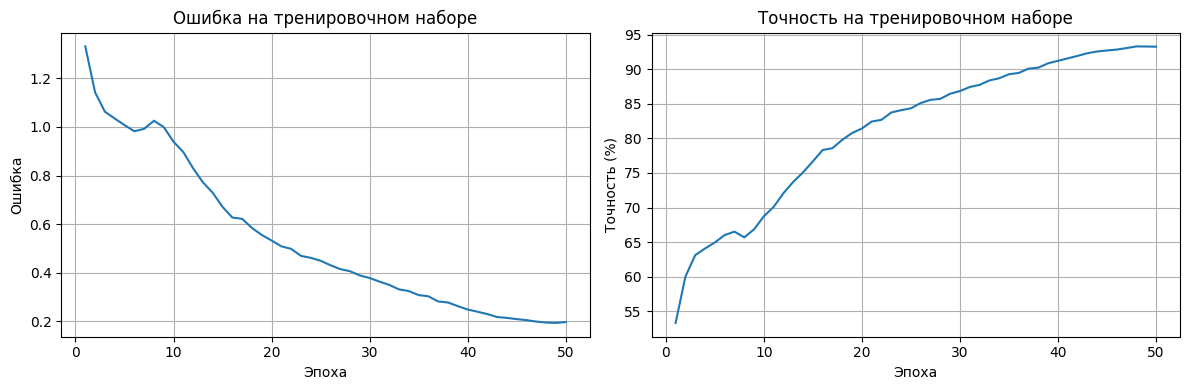

CPU times: user 1h 56min 8s, sys: 3.05 s, total: 1h 56min 11s
Wall time: 1h 54min 34s


In [9]:
%%time
learning_rate = 0.007
weight_decay = 1e-4
grad_clip = 0.1
epochs = 50
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=epochs, 
                                          steps_per_epoch=len(trainloader))

print(f'\nГиперпараметры:')
print(f'Скорость обучения: {learning_rate}')
print(f'Размер batch: {batch_size}')
print(f'Количество эпох: {epochs}')
print(f'Оптимизатор: AdamW')

train_losses = []
train_accuracies = []
torch.cuda.empty_cache()

print('\nНачало обучения...\n')

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_start_time = time.time()

    for i, data in enumerate(trainloader):
        inputs, labels = data
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        
        if grad_clip:
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_accuracy = 100 * correct / total
    epoch_time = time.time() - epoch_start_time

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Эпоха {epoch+1}/{epochs}:')
    print(f'  Ошибка на тренировочном наборе: {epoch_loss:.4f}')
    print(f'  Точность на тренировочном наборе: {epoch_accuracy:.2f}%')
    print(f'  Время выполнения эпохи: {epoch_time:.2f} секунд\n')


model.eval()
correct = 0
total = 0
test_loss = 0.0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels) # средняя ошибка по батчу - mean используется по умолчанию
        test_loss += loss.item() * images.size(0) # умножение на размер батча
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / total # делим на общее количество примеров
test_accuracy = 100 * correct / total

print('Результаты на тестовом наборе:')
print(f'Ошибка: {test_loss:.4f}')
print(f'Точность: {test_accuracy:.2f}%')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses)
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.title('Ошибка на тренировочном наборе')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies)
plt.xlabel('Эпоха')
plt.ylabel('Точность (%)')
plt.title('Точность на тренировочном наборе')
plt.grid(True)

plt.tight_layout()
plt.show()